In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import cleaned_econ_data
#sess = tf.InteractiveSession()

In [5]:
STEPS = 5000
DATA_PATH = '../data/QuarterlyResults.csv'
FEATURE_NAMES = ['funds-rate', 'oil-cpi', 'high-tax-rate', 'low-tax-rate', 'unemployment', 'snp']
# LABEL is GDP in this model

tf.logging.set_verbosity(tf.logging.ERROR)

In [6]:
## Data Functions
def import_data(path):
    with open(path, 'r') as f:
        dat = list(csv.reader(f))
        ar = np.array(dat)

    ## assumes columns are:
    ## index, DATE, funds_rate, oil_cpi, high_tax_rate, low_tax_rate, unemployment, real_gdp, snp
    
    ## remove index column
    ar = np.delete(ar,0,1)
    
    ## save DATE column and then remove
    dates = np.split(ar,8,1)[0].flatten()
    ar = np.delete(ar,0,1)
    
    ## convert data to floats
    data = np.array(ar.tolist(), dtype=float)
    
    ## split label (gdp) from features
    features = np.delete(data,5,1)
    label    = np.delete(data,[0,1,2,3,4,6],1).flatten()
    
    return (dates, features, label)

def split_data(dates, features, label, split_index):
    train_dates     = dates[:split_index]
    train_features  = features[:split_index]
    train_label     = label[:split_index]
    
    test_dates      = dates[split_index:]
    test_features   = features[split_index:]
    test_label      = label[split_index:]
    
    return (train_dates, train_features, train_label, test_dates, test_features, test_label)

def create_dataframe(numpy_data, feature_names):
    return pd.DataFrame(numpy_data, columns=feature_names)

def create_dataset(features, labels):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    return dataset.batch(30)

## Evalation Functions
def percentage_error(predicted, actual):
    if len(predicted)!=len(actual):
        print("Cannot compare datasets of different length")
    
    sum_percentage_error = 0
    for i in range(len(predicted)):
        sum_percentage_error += abs(predicted[i]-actual[i])/float(actual[i])
    
    return float(sum_percentage_error)/float(len(predicted)) 


In [7]:
(dates, features, label) = import_data(DATA_PATH)

(train_dates, train_features, train_label, test_dates, test_features, test_label) = split_data(dates, features, label, 168)

train_features_df = create_dataframe(train_features, FEATURE_NAMES)
test_features_df  = create_dataframe(test_features, FEATURE_NAMES)

In [26]:
#(train, test) = cleaned_econ_data.dataset()

# # Build the training input_fn.
# def input_train():
#     return (
#             # Shuffling with a buffer larger than the data set ensures
#             # that the examples are well mixed.
#             train.batch(128)
#             # Repeat forever
#             .repeat().make_one_shot_iterator().get_next())

# # Build the validation input_fn.
# def input_test():
#     return (test.batch(128)
#                     .make_one_shot_iterator().get_next())

feature_columns = [
        tf.feature_column.numeric_column(key="funds-rate"),
        tf.feature_column.numeric_column(key="oil-cpi"),
        tf.feature_column.numeric_column(key="high-tax-rate"),
        tf.feature_column.numeric_column(key="low-tax-rate"),
        tf.feature_column.numeric_column(key="unemployment"),
        tf.feature_column.numeric_column(key="snp")
]


In [27]:
error = []
minimum_error = 100
minimum_units = [0, 0]
# Iterate over varying hidden layer sizes
for i in range(15,40):
    error.append([])
    for j in range(15,40):
        print("NN units: ", i, j)
        
        # Build a DNNRegressor, with 2 i,j-unit hidden layers, with the feature columns defined above as input.
        model = tf.estimator.DNNRegressor(
                hidden_units=[i, j], feature_columns=feature_columns)

        # Train the model with STEPS iterations
        model.train(input_fn=lambda : create_dataset(train_features_df, train_label), steps=STEPS)

        # Evaluate how the model performs on data it has not yet seen.
        predictions = list(model.predict(input_fn=lambda : create_dataset(test_features_df, test_label)))
        
        predicted_gdp = [p['predictions'][0] for p in predictions]
        err = percentage_error(predicted_gdp, test_label.tolist())
        error[i-15].append(err)
        
        if err < minimum_error:
            print(predicted_gdp)
            minimum_units[0]=i
            minimum_units[1]=j
            minimum_error = err
        

NN units:  15 15
[1159.8368, 1225.4801, 1208.3654, 1237.1898, 1303.119, 1377.5135, 1450.7373, 1507.8391, 1536.9982, 1606.4899, 1642.985, 1701.744, 1670.0052, 1738.1754, 1747.0714, 1723.4259, 1606.9835, 1708.1252, 1795.3695, 1761.1215, 1884.296, 1965.7144, 2034.7972, 2122.853]
NN units:  15 16
[1587.8522, 1687.2324, 1664.0945, 1704.0903, 1801.9222, 1916.5671, 2021.8811, 2105.5388, 2140.426, 2253.8582, 2308.4749, 2405.6887, 2371.3748, 2475.7212, 2494.0676, 2462.9685, 2295.9836, 2443.9739, 2571.9446, 2517.9412, 2698.28, 2820.616, 2922.0735, 3047.908]
NN units:  15 17
[3946.4487, 4151.7773, 4092.5322, 4189.803, 4399.989, 4628.757, 4868.657, 5052.576, 5161.7656, 5362.4683, 5477.8135, 5644.9814, 5515.8804, 5724.4307, 5740.036, 5655.4707, 5271.8267, 5597.586, 5877.848, 5776.4907, 6172.4844, 6426.452, 6647.8022, 6938.259]
NN units:  15 18
NN units:  15 19
[8707.763, 9204.298, 9074.845, 9292.029, 9784.738, 10347.823, 10900.392, 11331.322, 11549.515, 12077.532, 12354.946, 12807.972, 12573.054, 1

NN units:  26 23
NN units:  26 24
NN units:  26 25
NN units:  26 26
NN units:  26 27
NN units:  26 28
NN units:  26 29
NN units:  26 30
NN units:  26 31
NN units:  26 32
NN units:  26 33
NN units:  26 34
NN units:  26 35
NN units:  26 36
NN units:  26 37
NN units:  26 38
NN units:  26 39
NN units:  27 15
NN units:  27 16
NN units:  27 17
NN units:  27 18
NN units:  27 19
NN units:  27 20
NN units:  27 21
NN units:  27 22
NN units:  27 23
NN units:  27 24
NN units:  27 25
NN units:  27 26
NN units:  27 27
NN units:  27 28
NN units:  27 29
NN units:  27 30
NN units:  27 31
NN units:  27 32
NN units:  27 33
NN units:  27 34
NN units:  27 35
NN units:  27 36
NN units:  27 37
NN units:  27 38
NN units:  27 39
NN units:  28 15
NN units:  28 16
NN units:  28 17
NN units:  28 18
NN units:  28 19
NN units:  28 20
NN units:  28 21
NN units:  28 22
NN units:  28 23
NN units:  28 24
NN units:  28 25
NN units:  28 26
NN units:  28 27
NN units:  28 28
NN units:  28 29
NN units:  28 30
NN units:  28 

In [28]:
error

[[0.9009294249827154,
  0.8600546729591841,
  0.6714766126412264,
  0.8980070527433792,
  0.25451849458421466,
  0.19854107158374748,
  0.6597518548313263,
  0.3638623420148152,
  0.5250008589898658,
  0.7328087940327593,
  0.8005667585466957,
  0.4786678998117477,
  0.5963846316406921,
  0.39587628667372615,
  0.2429121159660257,
  0.3028834953690822,
  0.21950219452682387,
  0.4241293150299876,
  0.3631901794397628,
  0.6745003048686801,
  0.12011115878248928,
  0.438775663386759,
  0.35748952660736727,
  0.1288664579142626,
  0.32660488991281306],
 [0.6426178466156599,
  0.4428229348102654,
  0.3448665607564965,
  0.7160674375615591,
  0.8391010009042295,
  0.11692875866485426,
  0.5366099452773241,
  0.09329406294709924,
  0.5264772425461393,
  0.3313611638833051,
  0.3063126521034612,
  0.21124984835340554,
  0.5519193754360382,
  0.5548137807120535,
  0.21790182498607158,
  0.09323303042467157,
  0.7632068319517874,
  0.16067361288104623,
  0.10240780937394779,
  0.08883056741365

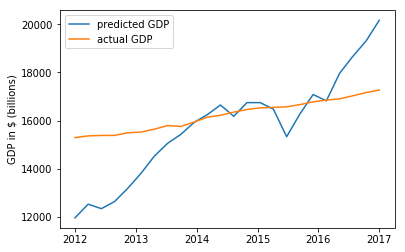

In [8]:
import matplotlib.pyplot as plt
predicted_gdp = [11951.063, 12522.651, 12335.747, 12633.686, 13186.793, 13809.33, 14519.355, 15051.848, 15424.636, 15919.724, 16245.595, 16647.541, 16178.233, 16745.973, 16746.73, 16472.658, 15328.398, 16273.573, 17084.172, 16819.709, 17964.088, 18670.71, 19307.377, 20172.775]
xvector = np.linspace (2012, 2017, len(predicted_gdp) )
plt.plot(xvector,predicted_gdp,xvector,test_label.tolist()) # 2012 to 2017 four data per year

plt.ylabel('GDP in $ (billions)')
plt.legend(['predicted GDP','actual GDP'])
plt.show()

In [9]:
plt.savefig('predicted-actual.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [29]:
minimum_error


0.07620674175657167

In [12]:
error

[[0.9009294249827154,
  0.8600546729591841,
  0.6714766126412264,
  0.8980070527433792,
  0.25451849458421466,
  0.19854107158374748,
  0.6597518548313263,
  0.3638623420148152,
  0.5250008589898658,
  0.7328087940327593,
  0.8005667585466957,
  0.4786678998117477,
  0.5963846316406921,
  0.39587628667372615,
  0.2429121159660257,
  0.3028834953690822,
  0.21950219452682387,
  0.4241293150299876,
  0.3631901794397628,
  0.6745003048686801,
  0.12011115878248928,
  0.438775663386759,
  0.35748952660736727,
  0.1288664579142626,
  0.32660488991281306],
 [0.6426178466156599,
  0.4428229348102654,
  0.3448665607564965,
  0.7160674375615591,
  0.8391010009042295,
  0.11692875866485426,
  0.5366099452773241,
  0.09329406294709924,
  0.5264772425461393,
  0.3313611638833051,
  0.3063126521034612,
  0.21124984835340554,
  0.5519193754360382,
  0.5548137807120535,
  0.21790182498607158,
  0.09323303042467157,
  0.7632068319517874,
  0.16067361288104623,
  0.10240780937394779,
  0.08883056741365

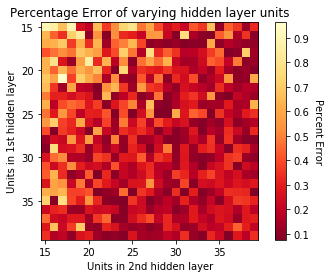

In [33]:
#labels = ["15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39"]
labels = ["0", "15", "20", "25", "30", "35", "40"]

fig, ax = plt.subplots()
im = ax.imshow(np.array(error), cmap=plt.cm.YlOrRd_r)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Percent Error", rotation=-90, va="bottom")

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_title("Percentage Error of varying hidden layer units")
plt.xlabel('Units in 2nd hidden layer')
plt.ylabel('Units in 1st hidden layer')


plt.show()

In [34]:
plt.savefig('nn-layers-heatmap.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>